In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler, label_binarize
from imblearn.over_sampling import SMOTE

import itertools
import numpy as np

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,  roc_curve, auc, accuracy_score
from matplotlib import pyplot as plt

%matplotlib inline

### UDF

In [2]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Load data 


#### Load data : Visiteurs


In [3]:
df_dim = pd.read_csv('./data/interim/user_dim.csv')


In [4]:
df_dim.sample(5)


id               ip  \
361461  afb2b0831970721cbc55c9fa3b2b07b0   190.57.154.101   
412509  8efe0fac1ee51b7a4f85dd27de5227aa     149.56.83.40   
308497  1df1543bf708d40bb8681956869164fb     91.227.230.2   
70232   cfd5c25a8fcbc57a47d831fcfd9a203b  176.106.206.117   
100429  393a5032acee5f4851eea233fa3741f5    178.76.216.67   

                                               user_agent  is_bot  
361461  Mozilla/5.0 (Windows NT 6.1; WOW64; rv:17.0) G...   False  
412509                                                NaN    True  
308497  Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...   False  
70232   Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...   False  
100429  Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...   False

#### Load data : request_interarrival_time


In [5]:
df_rit = pd.read_csv('./data/interim/request_interarrival_time_fact.csv')
df_rit['time'] = pd.to_datetime(df_rit['time'])


In [6]:
df_rit.sample(5)


id                time  \
449170  8efe0fac1ee51b7a4f85dd27de5227aa 2017-02-08 09:08:44   
129313  03e5604f87ed73ffb7a56442d40750c0 2016-02-18 15:22:12   
288589  3885b5e7d0f06ecd3134516897cecb83 2016-07-31 05:43:07   
157287  1647d22d2898a7628d8a58a580f1da0a 2016-02-18 22:50:30   
88417   5999dd3959948c2d57fb27647e8a5262 2016-02-18 07:13:46   

                              request_dst  delta_request_time  
449170           /administrator/index.php                 1.0  
129313           /administrator/index.php                 1.0  
288589  /templates/jp_hotel/js/moomenu.js                 0.0  
157287           /administrator/index.php                 0.0  
88417                     /administrator/                 NaN

#### Load data : session_interarrival_time


In [7]:
df_sit = pd.read_csv('./data/interim/session_interarrival_time_fact.csv')
df_sit['session_start'] = pd.to_datetime(df_sit['session_start'])
df_sit['next_session_start'] = pd.to_datetime(df_sit['next_session_start'])


In [8]:
df_sit.sample(5)


session_id                                id       session_start  \
56673      301528  174bb149295e859389bd8b015f00c007 2016-08-24 05:07:47   
64850      399517  d131f7ddbe414bedf16a1f226876e435 2017-02-03 18:53:37   
50434      328536  5da523867eaa4956c5d38be473fb0136 2016-10-06 03:40:37   
37873      271049  cdbfa9017aa788d69717d230ed3f058e 2016-07-11 07:36:39   
29190      151944  db27bcb1c105ab461b8437fcf2f2e5ec 2016-02-18 22:46:55   

              next_session_start  delta_session_time  
56673 2019-04-29 11:29:34.757262             35509.0  
64850 2017-02-03 23:45:46.000000              4180.0  
50434 2016-10-06 06:48:18.000000             45430.0  
37873 2019-04-29 11:25:07.176142                 NaN  
29190 2019-04-29 10:40:44.539275                 NaN

#### Load data : number_of_requests_in_session


In [9]:
df_nr = pd.read_csv('./data/interim/number_of_requests_in_session.csv')
df_nr['time'] = pd.to_datetime(df_nr['time'])


In [10]:
df_nr.sample(5)
 

id  session_id                time
131217  cc3091adf0eb2ed73d11ba47897185b4       95782 2016-02-18 15:39:12
117476  723f2614cde0a826941ab4fc036ade6f       83660 2016-02-18 13:15:11
214379  59a162036d13303d7ee1fd510d70f552      195329 2016-04-24 12:52:35
369472  247dc3aad8362db0a23687ced97089b1      357235 2016-12-06 17:39:24
142158  70d966d77aa62a110c8effc996706283      128024 2016-02-18 19:40:26

### Add event date


In [11]:
df_rit['event_date'] = df_rit['time'].apply(lambda x : x.date())


In [12]:
df_sit['event_date'] = df_sit['session_start'].apply(lambda x : x.date())


In [13]:
df_nr['event_date'] = df_nr['time'].apply(lambda x : x.date())


### Calcul des indicateurs RIT/SIT/NR


#### RIT


In [14]:
df_rit = df_rit.groupby(['id', 'event_date'], as_index=False)['delta_request_time'].mean()
df_rit.rename(columns={'delta_request_time': 'request_interarrival_time'}, inplace=True)


In [15]:
df_rit.sample(5)


id  event_date  request_interarrival_time
40279  f0dfd350db1da94fe20e1ac70b7b76a6  2016-01-21                        1.0
2738   0e873daaa5848582f191bba9a51bf42b  2016-11-11                        NaN
34943  d0fbdf5c46e7d46107afefd07a23189c  2016-03-09                        3.0
23119  880f67a8e7f887efe7e8af7b9e402230  2016-02-18                        0.2
29254  ae3a6cf00799cb0f22486eec50ff0ad0  2017-02-07                        1.0

#### SIT


In [16]:
df_sit = df_sit.groupby(['id', 'event_date'], as_index=False)['delta_session_time'].mean()
df_sit.rename(columns={'delta_session_time': 'session_interarrival_time'}, inplace=True)


In [17]:
df_sit.sample(5)


id  event_date  session_interarrival_time
34980  d298e1ecc6c5f4411795f11ab7f659da  2016-11-10                    85249.0
12901  4cd6ae5abb3399f89b8d9fab2bb93335  2016-12-17                        NaN
15969  5d7cacbb54f69f421d1ecb5dc92bd409  2016-02-18                        NaN
39344  ecc6d1aca87e7d207dee83aa307136e2  2015-12-16                    67905.0
37002  dee6f8f2d37be7625c06528f9b6a5b4b  2016-02-19                        NaN

#### NR


In [18]:
df_nr = df_nr.groupby(['id', 'event_date', 'session_id'], as_index=False).size()\
    .to_frame('number_of_requests_in_session').reset_index().groupby(['id', 'event_date'], as_index=False)['number_of_requests_in_session'].mean()


In [19]:
df_nr.sample(5)


id  event_date  \
7539   2d2946f9fe72ed25e43df33a9deaeba0  2016-02-18   
22934  872d069bfe354e3cbfd3fe7b12c8a319  2016-08-30   
35132  d1ee8cc9a5a6a45e8acc404aa3b85753  2016-02-18   
10255  3d3bdb279ae3876f3afafd6e28f0f2b4  2016-07-17   
26489  9d494ad1837f3ead8d5758d1f549d40e  2016-06-24   

       number_of_requests_in_session  
7539                             6.0  
22934                            1.0  
35132                            6.0  
10255                            1.0  
26489                            1.0

### Regrouper les données


In [20]:
df = pd.merge(df_dim, df_rit, on='id')
df = pd.merge(df, df_sit, on=['id', 'event_date'])
df = pd.merge(df, df_nr, on=['id', 'event_date'])


In [21]:
df.sample(5)


id              ip  \
2815378  1adbe0f2df8dc9ca52a45faef096d917  195.154.216.79   
1561465  925ed137d43c546c2dd3138ef10af572   176.15.68.185   
2274070  b222a6e5f371e396ba9dca1a3d9b1443  195.154.216.79   
1837450  5235a62e2f3ea7676327ac2683de3997   89.144.211.10   
882152   af6d29b50b0b8838be4db80b22740f53   85.25.210.234   

                                                user_agent  is_bot  \
2815378  Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...   False   
1561465  Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...   False   
2274070  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...   False   
1837450  Mozilla/5.0 (iPad; CPU OS 9_3_2 like Mac OS X)...   False   
882152   Mozilla/5.0 (compatible; seoscanners.net/1; +s...    True   

         event_date  request_interarrival_time  session_interarrival_time  \
2815378  2016-08-18                1219.000000               12176.000000   
1561465  2016-02-18                   0.000000                        NaN   
2274070  2016-08-23                1293.000000                8691.090909   
1837450  2016-05-25                   1.211864                        NaN   
882152   2016-08-25                        NaN               34129.000000   

         number_of_requests_in_session  
2815378                       1.333333  
1561465                       6.000000  
2274070                       1.181818  
1837450                     119.000000  
882152                        1.000000

### Selection des données pour : analyser distribution + ML


In [22]:
train = df[(df['event_date'] >= datetime.date(year=2016,month=1,day=1)) 
         & (df['event_date'] <= datetime.date(year=2016,month=1,day=7))]

test = df[(df['event_date'] >= datetime.date(year=2016,month=1,day=8))
        & (df['event_date'] <= datetime.date(year=2016,month=1,day=14))]


In [23]:
# Nombre d'enregistrement train
train.shape


(8531, 8)

In [24]:
# Nombre d'enregistrement test
test.shape


(12119, 8)

#### Distribution Bot/Humain


##### Distribution Bot/Humain : Train


In [25]:
train.groupby(['is_bot'])['id'].nunique()


is_bot
False    159
True     131
Name: id, dtype: int64

##### Distribution Bot/Humain : Test


In [26]:
test.groupby(['is_bot'])['id'].nunique()


is_bot
False    175
True     107
Name: id, dtype: int64

### Distribution train : RIT/SIT/NR


In [27]:
train_bot = train.loc[train['is_bot'] == True]
train_human = train.loc[train['is_bot'] == False]


#### Train - RIT


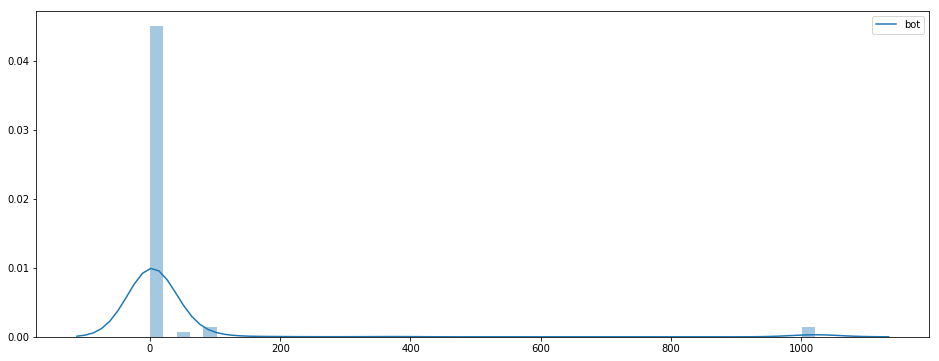

In [28]:
plt.figure(figsize=(16, 6))
sns.distplot(train_bot[['request_interarrival_time']].dropna(), hist=True, kde_kws={"label": "bot"})


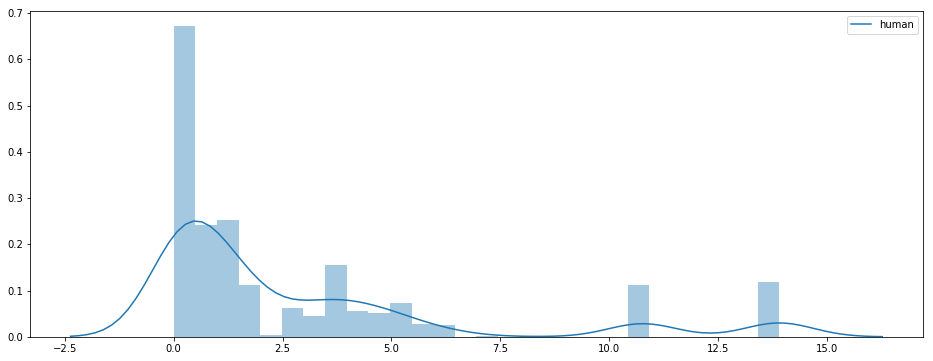

In [29]:
plt.figure(figsize=(16, 6))
sns.distplot(train_human[['request_interarrival_time']].dropna(), hist=True, kde_kws={"label": "human"})


#### Train - SIT


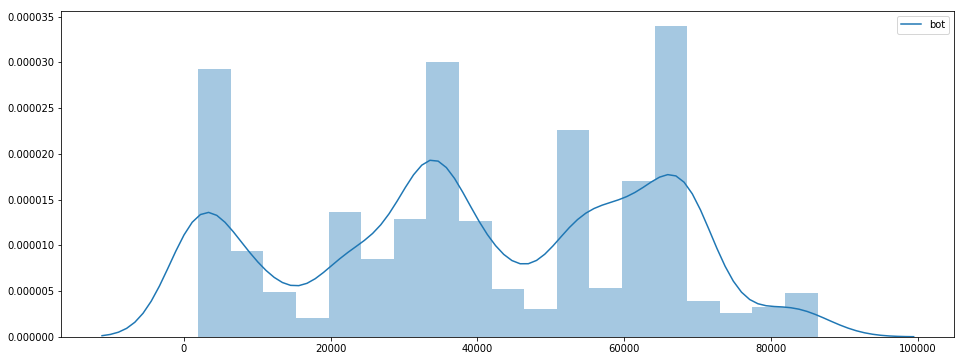

In [30]:
plt.figure(figsize=(16, 6))
sns.distplot(train_bot[['session_interarrival_time']].dropna(), hist=True, kde_kws={"label": "bot"})


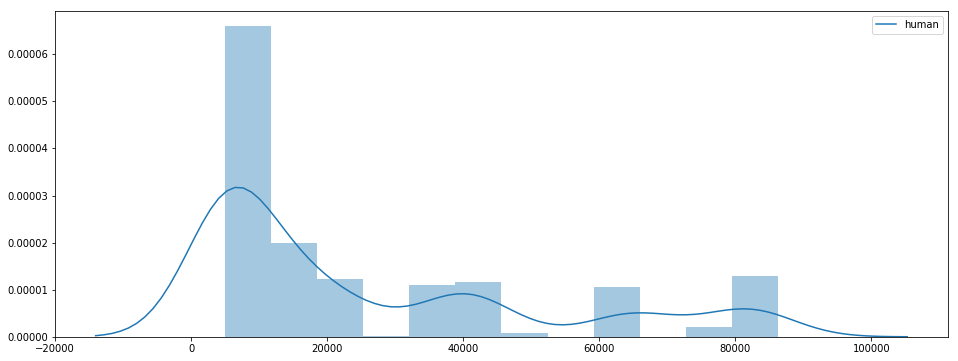

In [31]:
plt.figure(figsize=(16, 6))
sns.distplot(train_human[['session_interarrival_time']].dropna(), hist=True, kde_kws={"label": "human"})


#### Train - NR


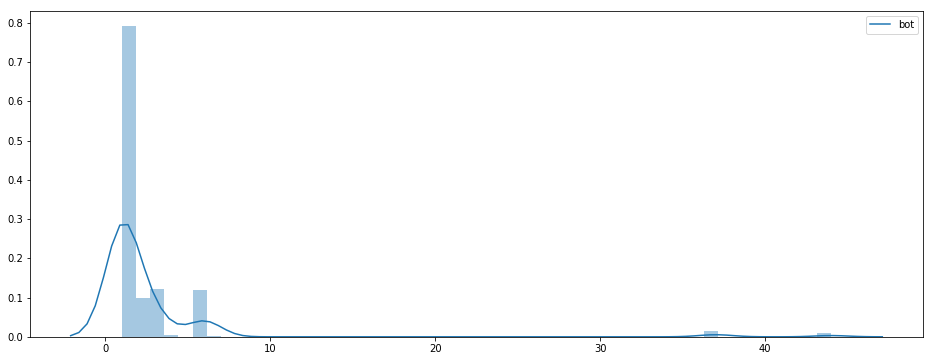

In [32]:
plt.figure(figsize=(16, 6))
sns.distplot(train_bot[['number_of_requests_in_session']], hist=True, kde_kws={"label": "bot"})


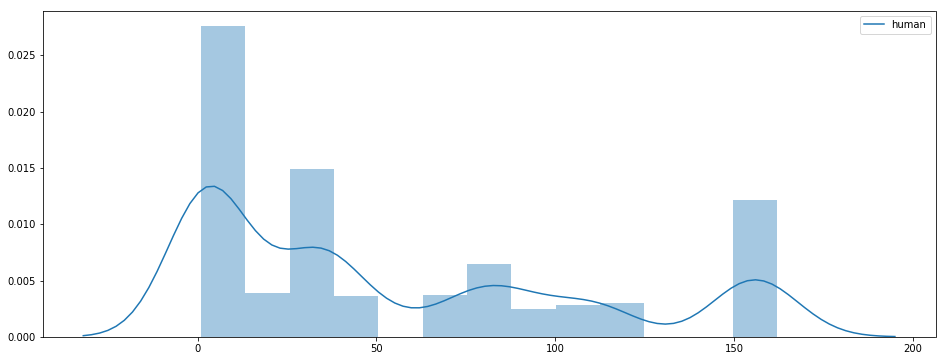

In [33]:
plt.figure(figsize=(16, 6))
sns.distplot(train_human[['number_of_requests_in_session']], hist=True, kde_kws={"label": "human"})


## Machine learning 


#### Nettoyage des données : remplacer la valeur NULL de RIN et SIN par -1


In [35]:
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)


#### Garder les colonnes utiles


In [36]:
X_train = train[['request_interarrival_time', 'session_interarrival_time', 'number_of_requests_in_session']].values
X_test = test[['request_interarrival_time', 'session_interarrival_time', 'number_of_requests_in_session']].values

y_train = train.loc[:, 'is_bot'].values
y_test = test.loc[:, 'is_bot'].values


In [37]:
X_train


array([[-1.00000000e+00,  1.04660000e+04,  1.00000000e+00],
       [-1.00000000e+00,  1.04660000e+04,  1.00000000e+00],
       [-1.00000000e+00,  1.04660000e+04,  1.00000000e+00],
       ...,
       [ 4.21052632e-01, -1.00000000e+00,  2.00000000e+01],
       [ 4.21052632e-01, -1.00000000e+00,  2.00000000e+01],
       [-1.00000000e+00, -1.00000000e+00,  1.00000000e+00]])

In [38]:
y_train


array([ True,  True,  True, ..., False, False, False])

#### Normalisation des données entre -1 et 1


In [39]:
X_train = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_train)
X_test = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_test)


In [40]:
X_train


array([[-1.        , -0.75753996, -1.        ],
       [-1.        , -0.75753996, -1.        ],
       [-1.        , -0.75753996, -1.        ],
       ...,
       [-0.99722179, -1.        , -0.76397516],
       [-0.99722179, -1.        , -0.76397516],
       [-1.        , -1.        , -1.        ]])

#### Equilibrage des données : Générer de fausses visites similaires à celles des bot (classe la moins fréquente)


In [41]:
print("X_train dataset size: ", X_train.shape)
print("y_train dataset size: ", y_train.shape)
print("X_test dataset size: ", X_test.shape)
print("y_test dataset size: ", y_test.shape)


X_train dataset size:  (8531, 3)
y_train dataset size:  (8531,)
X_test dataset size:  (12119, 3)
y_test dataset size:  (12119,)


In [42]:
print("Before OverSampling, counts of label BOT: {}".format(sum(y_train==True)))
print("Before OverSampling, counts of label HUMAN: {} \n".format(sum(y_train==False)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label BOT: {}".format(sum(y_train_res==True)))
print("After OverSampling, counts of label HUMAN: {}".format(sum(y_train_res==False)))


Before OverSampling, counts of label BOT: 5415
Before OverSampling, counts of label HUMAN: 3116 

After OverSampling, the shape of train_X: (10830, 3)
After OverSampling, the shape of train_y: (10830,) 

After OverSampling, counts of label BOT: 5415
After OverSampling, counts of label HUMAN: 5415


In [43]:
X_train_res


array([[-1.        , -0.75753996, -1.        ],
       [-1.        , -0.75753996, -1.        ],
       [-1.        , -0.75753996, -1.        ],
       ...,
       [-1.        , -0.13022933, -1.        ],
       [-0.99687195, -1.        , -0.13043478],
       [-0.99212401, -1.        , -0.56521739]])

### Entrainement d'un modèle de classification (RF)


In [44]:
from sklearn.ensemble import RandomForestClassifier


#### Paramétrer le modèle


In [45]:
clf = RandomForestClassifier(bootstrap=False, 
                            criterion='gini', 
                            max_depth=5, 
                            max_features='auto',
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0,
                            min_impurity_split=None, 
                            min_samples_leaf=10,
                            min_samples_split=10, 
                            min_weight_fraction_leaf=0.0,
                            n_estimators=150,
                            n_jobs=-1, 
                            oob_score=False, 
                            random_state=42,
                            verbose=0, 
                            warm_start=False,)


#### Entrainement (sur les données équilibrées)


In [46]:
clf = clf.fit(X_train_res, y_train_res)


#### Calculer les prédictions sur les données de test


In [47]:
y_pred = clf.predict(X_test)


#### Score : accuracy


In [48]:
accuracy_score(y_test, y_pred)
 

0.875567291030613

#### Score : classification_report


In [49]:
print(classification_report(y_test, y_pred, target_names=['Human', 'Bot']))


              precision    recall  f1-score   support

       Human       0.95      0.80      0.87      6421
         Bot       0.81      0.96      0.88      5698

   micro avg       0.88      0.88      0.88     12119
   macro avg       0.88      0.88      0.88     12119
weighted avg       0.89      0.88      0.88     12119



#### Score : Matrice confusion 


In [50]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)


Confusion matrix, without normalization
[[5156 1265]
 [ 243 5455]]


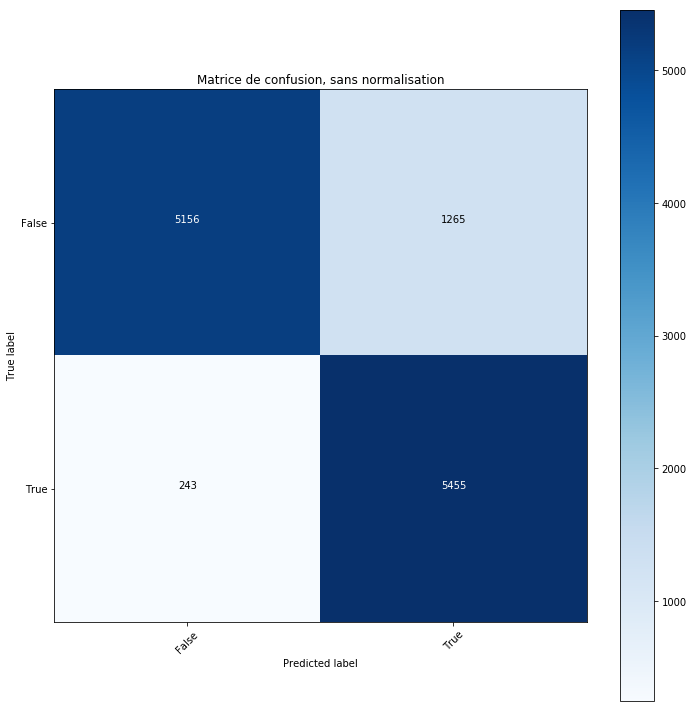

In [51]:
# Plot non-normalized confusion matrix
class_names = clf.classes_
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title = 'Matrice de confusion, sans normalisation')


Normalized confusion matrix
[[0.80299019 0.19700981]
 [0.04264654 0.95735346]]


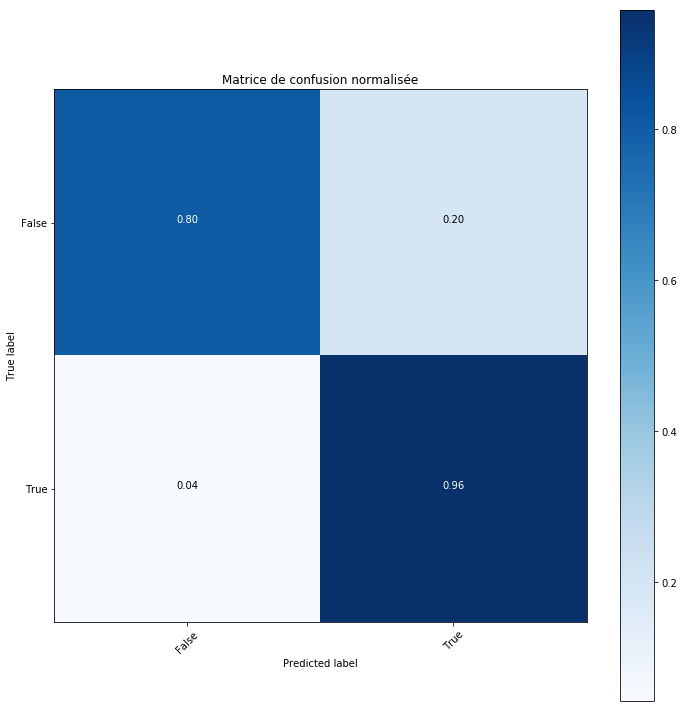

In [52]:
 # Plot normalized confusion matrix
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title = 'Matrice de confusion normalisée')


#### Score : Courbe ROC 


In [53]:
fpr, tpr, _ = roc_curve(label_binarize(y_test, clf.classes_), 
                        clf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)


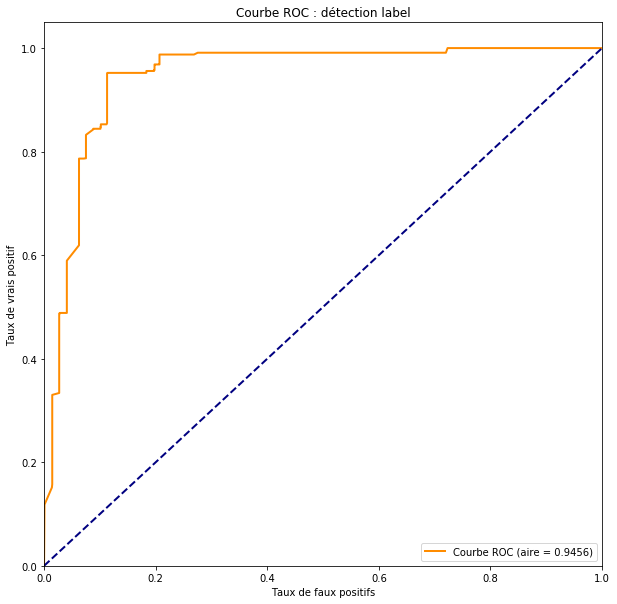

In [54]:
plt.figure(figsize = (10, 10))
plt.plot(fpr, tpr, 
         color='darkorange',
         lw=2, 
         label='Courbe ROC (aire = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positif')
plt.title('Courbe ROC : détection label')
plt.legend(loc = "lower right")
plt.show()
